In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
daily = pd.read_csv("../data/raw/call-center-data-v3-daily.csv")
intraday = pd.read_csv("../data/raw/intraday-profiles.csv")

In [3]:
daily

,Date,Incoming Calls,Talk Duration (AVG),Waiting Time (AVG),Product Group
0,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT
1,2025-03-02,32,163,70,PRODUCT_ABC_DESKTOP_EN_CHAT
2,2025-03-03,271,172,120,PRODUCT_ABC_DESKTOP_EN_CHAT
3,2025-03-04,212,163,154,PRODUCT_ABC_DESKTOP_EN_CHAT
4,2025-03-05,247,173,228,PRODUCT_ABC_DESKTOP_EN_CHAT
...,...,...,...,...,...
363,2025-05-27,89,202,64,PRODUCT_ABC_MOBILE_EN_PHN
364,2025-05-28,54,220,73,PRODUCT_ABC_MOBILE_EN_PHN
365,2025-05-29,95,200,100,PRODUCT_ABC_MOBILE_EN_PHN
366,2025-05-30,115,251,221,PRODUCT_ABC_MOBILE_EN_PHN


In [4]:
intraday

,Product Group,Day of Week,Interval Start,Intraday Arrival
0,PRODUCT_ABC_DESKTOP_EN_CHAT,Monday,00:00:00,0.0
1,PRODUCT_ABC_DESKTOP_EN_CHAT,Monday,00:30:00,0.0
2,PRODUCT_ABC_DESKTOP_EN_CHAT,Monday,01:00:00,0.0
3,PRODUCT_ABC_DESKTOP_EN_CHAT,Monday,01:30:00,0.0
4,PRODUCT_ABC_DESKTOP_EN_CHAT,Monday,02:00:00,0.0
...,...,...,...,...
1339,PRODUCT_ABC_MOBILE_EN_PHN,Sunday,21:30:00,0.0
1340,PRODUCT_ABC_MOBILE_EN_PHN,Sunday,22:00:00,0.0
1341,PRODUCT_ABC_MOBILE_EN_PHN,Sunday,22:30:00,0.0
1342,PRODUCT_ABC_MOBILE_EN_PHN,Sunday,23:00:00,0.0


In [5]:
daily["Date"] = pd.to_datetime(daily["Date"])
daily["Day of Week"] = daily["Date"].dt.day_name()

In [6]:
merged = daily.merge(intraday, how="left", on=["Product Group", "Day of Week"])

In [7]:
merged["Interval Calls"] = (
    merged["Incoming Calls"] * merged["Intraday Arrival"]
)

In [8]:
interval_seconds = 30 * 60  # 30 minutes
merged["lambda"] = merged["Interval Calls"] / interval_seconds

In [9]:
# offered load: the average number of agents that would be busy if you had unlimited agents available
merged["offered_load"] = merged["lambda"] * merged["Talk Duration (AVG)"]

In [10]:
merged["N_min"] = np.ceil(merged["offered_load"]).astype(int)
merged["N_max"] = merged["N_min"] + 10

In [11]:
merged

,Date,Incoming Calls,Talk Duration (AVG),Waiting Time (AVG),Product Group,Day of Week,Interval Start,Intraday Arrival,Interval Calls,lambda,offered_load,N_min,N_max
0,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,00:00:00,0.0,0.0,0.0,0.0,0,10
1,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,00:30:00,0.0,0.0,0.0,0.0,0,10
2,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,01:00:00,0.0,0.0,0.0,0.0,0,10
3,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,01:30:00,0.0,0.0,0.0,0.0,0,10
4,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,02:00:00,0.0,0.0,0.0,0.0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17659,2025-05-31,70,240,152,PRODUCT_ABC_MOBILE_EN_PHN,Saturday,21:30:00,0.0,0.0,0.0,0.0,0,10
17660,2025-05-31,70,240,152,PRODUCT_ABC_MOBILE_EN_PHN,Saturday,22:00:00,0.0,0.0,0.0,0.0,0,10
17661,2025-05-31,70,240,152,PRODUCT_ABC_MOBILE_EN_PHN,Saturday,22:30:00,0.0,0.0,0.0,0.0,0,10
17662,2025-05-31,70,240,152,PRODUCT_ABC_MOBILE_EN_PHN,Saturday,23:00:00,0.0,0.0,0.0,0.0,0,10


In [12]:
merged.iloc[25]

Date                           2025-03-01 00:00:00
Incoming Calls                                 298
Talk Duration (AVG)                            184
Waiting Time (AVG)                             284
Product Group          PRODUCT_ABC_DESKTOP_EN_CHAT
Day of Week                               Saturday
Interval Start                            12:30:00
Intraday Arrival                          0.090834
Interval Calls                           27.068521
lambda                                    0.015038
offered_load                              2.767004
N_min                                            3
N_max                                           13
Name: 25, dtype: object

## Probability of Wait

$$ Pw = \frac{\frac{a^N}{N!} \cdot \frac{N}{N - a}}{\sum_{k=0}^{N-1} \frac{a^k}{k!} + \frac{a^N}{N!} \cdot \frac{N}{N - a}} $$

Where:  
- $a$ = offered load (Erlangs)  
- $N$ = number of agents  
- $Pw$ = probability that an arriving call has to wait

In [13]:
def calculate_pw(a, N):
    if a == 0:
        return 0.0

    # sum_{k=0}^{N-1} a^k / k! iteratively
    sum_terms = 1.0  # k=0 term
    term = 1.0
    for k in range(1, N):
        term *= a / k
        sum_terms += term

    # numerator = a^N / N! * N / (N - a)
    numerator = term * (a / N) * (N / (N - a))
    denom = sum_terms + numerator
    pw = numerator / denom
    pw = min(max(pw, 0.0), 1.0)  # clamp between 0 and 1
    return pw

## Service Level

$$ SL(N) = 1 - Pw \cdot e^{-(N - a) \mu T} $$

Where:  
- $SL(N)$ = service level achieved with N agents  
- $Pw$ = probability all agents are busy (from Erlang-C)  
- $a$ = offered load (Erlangs)  
- $N$ = number of agents  
- $mu = \frac{1}{\text{AHT}}$ (service rate, per second)  
- $T$ = target service time (seconds)  

In [14]:
def calculate_sl(pw, a, n, mu, t):
    sl = 1 - pw * math.exp(-(n - a) * mu * t)
    return sl

In [15]:
def find_min_n(a, n_min, n_max, aht, sl_target=0.8, t=20):
    mu = 1 / aht
    for N in range(n_min, n_max + 1):
        pw = calculate_pw(a, N)
        sl = calculate_sl(pw, a, N, mu, t)
        if sl >= sl_target:
            return pd.Series([N, sl])
    # if no N reaches SL_target
    pw = calculate_pw(a, n_max)
    sl = calculate_sl(pw, a, n_max, mu, t)
    return pd.Series([n_max, sl])

In [16]:
merged[["N_on_phone", "achieved_SL"]] = merged.apply(
    lambda row: find_min_n(
        row["offered_load"],
        row["N_min"],
        row["N_max"],
        row["Talk Duration (AVG)"],
        0.8,
        20,
    ),
    axis=1,
)

In [17]:
merged["occupancy"] = merged["offered_load"] / merged["N_on_phone"]

In [18]:
merged.iloc[20:30]

,Date,Incoming Calls,Talk Duration (AVG),Waiting Time (AVG),Product Group,Day of Week,Interval Start,Intraday Arrival,Interval Calls,lambda,offered_load,N_min,N_max,N_on_phone,achieved_SL,occupancy
20,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,10:00:00,0.059620,17.766662,0.009870,1.816148,2,12,4.0,0.895958,0.454037
21,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,10:30:00,0.073658,21.950165,0.012195,2.243795,3,13,4.0,0.802229,0.560949
22,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,11:00:00,0.086726,25.844324,0.014358,2.641864,3,13,5.0,0.878706,0.528373
23,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,11:30:00,0.091536,27.277828,0.015154,2.788400,3,13,5.0,0.852967,0.557680
24,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,12:00:00,0.091861,27.374656,0.015208,2.798298,3,13,5.0,0.851112,0.559660
25,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,12:30:00,0.090834,27.068521,0.015038,2.767004,3,13,5.0,0.856926,0.553401
26,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,13:00:00,0.080223,23.906464,0.013281,2.443772,3,13,5.0,0.908570,0.488754
27,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,13:30:00,0.069064,20.580944,0.011434,2.103830,3,13,4.0,0.836893,0.525957
28,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,14:00:00,0.059410,17.704269,0.009836,1.809770,2,12,4.0,0.897088,0.452442
29,2025-03-01,298,184,284,PRODUCT_ABC_DESKTOP_EN_CHAT,Saturday,14:30:00,0.047948,14.288559,0.007938,1.460608,2,12,3.0,0.811394,0.486869


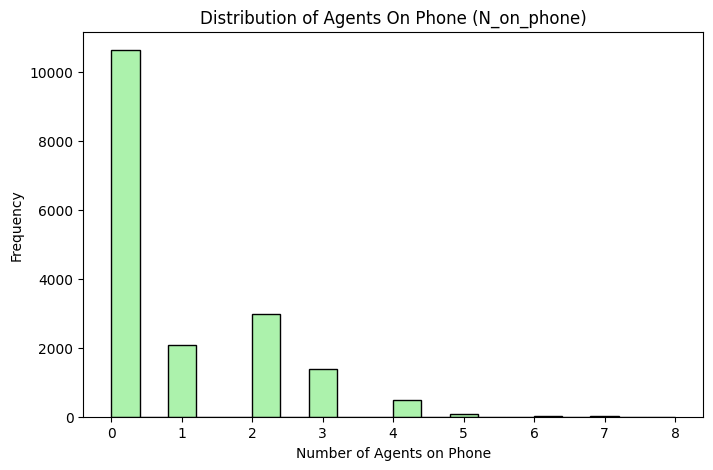

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(merged["N_on_phone"], bins=20, kde=False, color="lightgreen")
plt.title("Distribution of Agents On Phone (N_on_phone)")
plt.xlabel("Number of Agents on Phone")
plt.ylabel("Frequency")
plt.show()

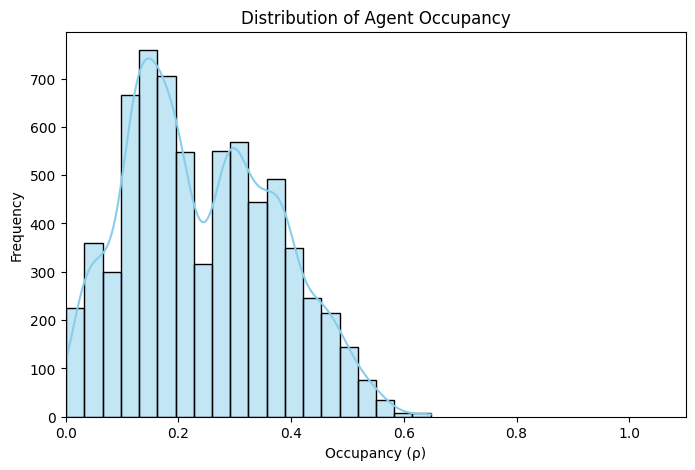

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(merged["occupancy"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Agent Occupancy")
plt.xlabel("Occupancy (ρ)")
plt.ylabel("Frequency")
plt.xlim(0, 1.1)  # occupancy is between 0 and 1
plt.show()

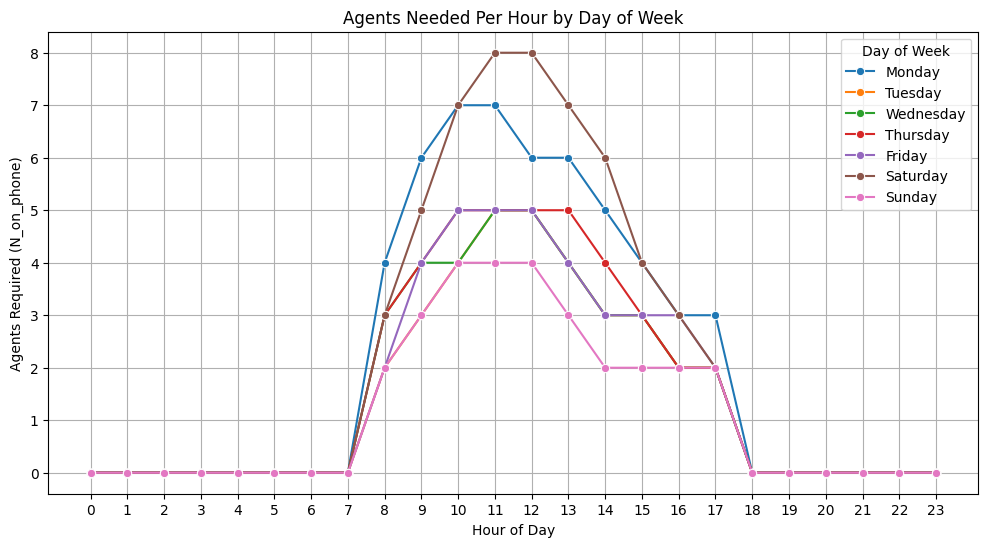

In [22]:
merged['Hour'] = merged['Interval Start'].astype(str).str.slice(0, 2)
merged['Hour'] = merged['Hour'].astype(int)

hourly_staffing = (
    merged.groupby(['Day of Week', 'Hour'])['N_on_phone']
    .max()
    .reset_index()
)

dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

hourly_staffing['Day of Week'] = pd.Categorical(
    hourly_staffing['Day of Week'],
    categories=dow_order,
    ordered=True
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=hourly_staffing.sort_values(['Day of Week', 'Hour']),
    x='Hour',
    y='N_on_phone',
    hue='Day of Week',
    hue_order=dow_order,    # enforce legend order
    marker='o'
)

plt.title('Agents Needed Per Hour by Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Agents Required (N_on_phone)')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()
